In [44]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み


In [59]:
df_cross = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR
    + "/df_cross_{0}.pkl".format("mrna_agilent_microarray_zscores_ref_diploid_samples")
)
df_cross.head()

,PATIENT_ID,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CD164,MOB3A,KIF25-AS1,OR1J2,GNG5,...,INPP5F,ZNF683,MFAP1,TMEM168,STUB1,ELANE,SHISA2,BCAT1,NCKAP1L,CATSPERD,PSMC3IP,TEAD1,GRHPR,EGLN2,TBC1D4,ANGPTL2,ENOX1,SBF2-AS1,VN1R4,UGGT1,VPS72,CSMD3,CC2D1A,IGSF9,FAM71A
0,MB-0000,False,False,NaN,claudin-low,-0.0120,-1.1056,4.5196,0.0329,0.3862,-2.0219,-0.2429,2.1378,0.5495,1.8284,-0.8398,-0.1142,-1.7540,-1.2755,0.0196,-0.0522,-1.2824,0.5897,-0.3029,-0.5228,...,0.9475,-0.9120,-0.3074,0.1521,-0.5106,1.3997,-0.9917,-0.1982,0.0272,0.4792,-0.6417,0.5771,0.0594,-1.2168,0.8393,1.5746,1.4772,-1.2587,0.3048,-1.2102,0.1724,-0.0968,-0.4385,-1.2266,-0.7888
1,MB-0002,False,NaN,NaN,LumA,-0.9754,-1.2345,-0.2178,0.0345,1.3780,-1.3438,-0.1896,0.1974,1.5447,2.2324,-0.5702,1.2907,0.5034,-0.3811,-1.0740,0.4406,0.6710,0.6737,-0.5655,0.4570,...,-1.1211,-0.9657,-1.1362,0.8143,0.5264,0.3201,0.9288,-0.5112,-1.7165,-3.2289,0.9063,2.4823,0.4596,-1.2913,-1.1835,0.6860,-0.2834,-0.1178,-0.9119,-0.0436,0.0931,-0.5014,-0.0856,0.5231,1.3184
2,MB-0005,False,False,True,LumB,-1.2369,-0.6683,0.0388,1.3961,-0.1890,1.5054,-0.1051,1.9259,-1.4087,0.8772,0.0634,0.5388,-1.8249,-1.8733,-2.0042,4.5635,-1.3689,-0.4228,0.5096,-0.6763,...,-0.2585,-1.3112,-0.1760,1.3253,-0.9020,-1.9443,0.7425,1.6060,-0.6394,0.1655,-0.1446,1.3467,-1.2727,-1.6672,0.6575,0.7729,-1.0080,-0.6883,-0.4368,-2.0045,0.2941,-0.0720,-0.1664,1.3332,1.5020
3,MB-0006,False,False,NaN,LumB,-1.4532,-0.6241,-0.9954,0.9550,-0.3821,-0.5567,2.1362,0.8176,-1.1097,-0.5361,-0.9623,-0.6191,-1.0476,-2.5493,-1.6123,5.6814,-1.3153,-0.3836,0.9926,-0.0480,...,-0.2523,0.1199,0.0295,-1.5261,-1.7477,-1.5714,1.3007,2.1700,-1.0093,-0.5112,-1.3530,0.4042,0.5895,-1.4498,0.3101,0.4233,0.3079,-1.2554,1.8796,-1.3191,-1.5679,-0.4885,0.6320,-0.8236,0.2000
4,MB-0008,True,True,True,LumB,-1.2669,-0.2296,2.0700,-0.7105,0.3735,1.3603,0.5765,-0.4034,-1.0353,1.4386,2.1507,-0.3227,-0.1100,-0.3917,-0.9916,-0.5012,-1.4905,-0.2076,-0.1656,-0.5703,...,-0.2081,-0.7431,0.3272,0.2224,0.3766,-0.5099,-1.1252,-0.1921,-0.6421,0.2314,0.7798,2.2265,-0.3720,0.4236,-1.9978,-0.1704,-0.2313,-2.0527,0.3099,-1.3665,0.5494,-0.2719,-0.1021,-0.6526,-1.2493


<AxesSubplot:xlabel='STAT5B', ylabel='Count'>

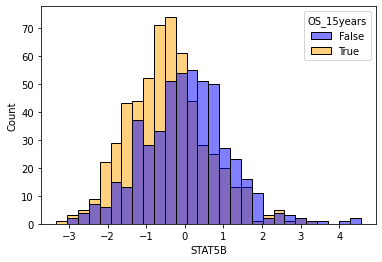

In [62]:
sns.histplot(
    x="STAT5B", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)

# Draw KM line

to use OS_MONTHS and OS_STATUS, read raw patient data

In [68]:
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_MB.pkl")
df_merged = pd.merge(
    df_cross,
    df_MB.drop("CLAUDIN_SUBTYPE", axis=1),
    right_on="PATIENT_ID",
    left_on="PATIENT_ID",
)

In [69]:
def plot_KM(target: str, threshold: float = 0, save_path: str = None):
    ax = None
    df_merged["OS_STATUS_INT"] = df_merged["OS_STATUS"].replace(
        {"0:LIVING": 0, "1:DECEASED": 1}
    )
    df_merged["target_gene"] = df_merged[target].apply(
        lambda x: 1 if x > threshold else 0
    )
    plt.figure()
    kmf = KaplanMeierFitter()
    for name, group in df_merged.groupby("target_gene"):
        kmf.fit(
            group["OS_MONTHS"],
            event_observed=group["OS_STATUS_INT"],
            label="is deceased: {0}".format(name),
        )
        ax = kmf.plot(ax=ax) if ax else kmf.plot()
    plt.title(target)
    if save_path:
        plt.savefig("{0}/{1}.png".format(save_path, target))
    else:
        plt.show()

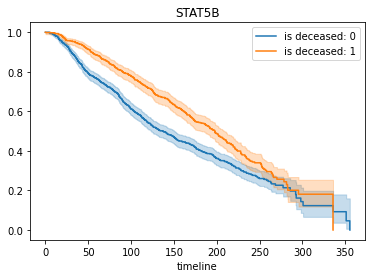

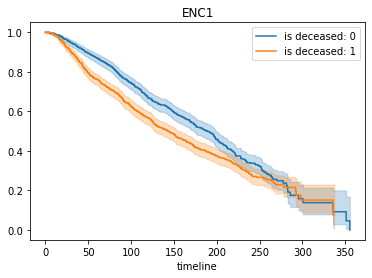

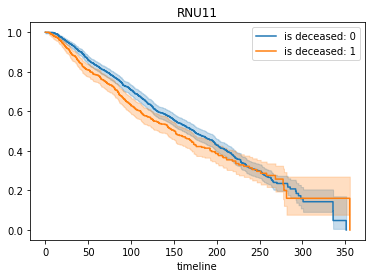

In [70]:
gene_list = [
    # "RACGAP1",
    "STAT5B",
    # "RBBP8",
    "ENC1",
    "RNU11",
    # "UHRF1",
    # "S100P",
    # "FGF13",
    # "HIST1H2BF",
]

for t in gene_list:
    plot_KM(t, 0, "./")

# Draw Cox proportional hazard model

Iteration 1: norm_delta = 0.24250, step_size = 0.9500, log_lik = -6804.90663, newton_decrement = 33.44682, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.02076, step_size = 0.9500, log_lik = -6770.89517, newton_decrement = 0.22895, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00108, step_size = 0.9500, log_lik = -6770.66650, newton_decrement = 0.00062, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -6770.66588, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1743 total observations, 737 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1743
number of events observed = 1006
   partial log-likelihood = -6770.67
         time fit was run = 2022-09-03 15:17:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
STAT5B     -0.17       0.85       0.03            -0.23            -0.11                 0.80                 0.90
ENC1        0.16       1.18       0.03             0.10             0.22                 1.11                 1.25
RNU11       0.04       1.04       0.04            -0.03             0.11                 0.97                 1.11

            cmp to     z      p   -log2(p)
covariate                                 
STAT5B        0.00 -5.64 <0.005      25.80
ENC1          0.00  5.22 <0.005      22.42
RNU11         0.00  1.05   0.30       1.76
---
Concordance = 0.60
Partial AIC = 13547.33
log-likelihood ratio test = 68.48 on 3 df
-log2(p) of ll-ratio test = 46.66

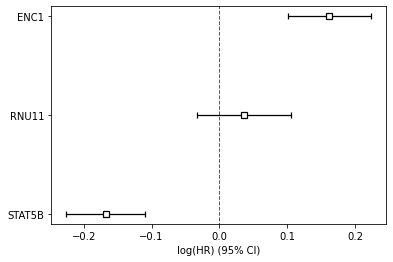

In [75]:
gene_list = [
    # "OS_YEARS",
    "OS_MONTHS",
    "OS_STATUS_INT",
    # "RACGAP1",
    "STAT5B",
    # "RBBP8",
    "ENC1",
    "RNU11",
    # "UHRF1",
    # "S100P",
    # "FGF13",
    # "HIST1H2BF",
]

cph = CoxPHFitter()
cph.fit(
    df_merged[gene_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig("cph.png")